In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

df = pd.read_csv('Breast_GSE45827.csv')
# Display the first few rows of the DataFrame
#print(df.columns.tolist())
df = df.set_index('samples')
# separate features and labels
X = df.iloc[:, 1:].values # Features are all columns except the first/second
y = df.iloc[:, 0].values # Labels are the second column
print(X.shape) # debug
print(set(y)) # verify labels

# Encode labels as integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(set(y)) # verify labels are encoded as integers

#split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

#normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape) # debug

(151, 54675)
{'HER', 'normal', 'cell_line', 'luminal_A', 'luminal_B', 'basal'}
{'HER', 'normal', 'cell_line', 'luminal_A', 'luminal_B', 'basal'}
(120, 54675)


In [ ]:
#feature selection
selector = VarianceThreshold(threshold=0.1)
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

#Select top N genes based on variance
gene_variances = np.var(X_train, axis=0)
top_n_genes = 250  # This can be adjusted based on RAM usage - 250 is MAX for MACOS
top_indices = np.argsort(gene_variances)[-top_n_genes:]
X_train = X_train[:, top_indices]
X_test = X_test[:, top_indices]

print(f"After feature selection, the shape of X_train is: {X_train.shape}")

#Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#Dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

After feature selection, the shape of X_train is: (120, 250)


In [ ]:
!pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201

In [ ]:
# Check if MPS (Metal Performance Shaders) is available: for MacOS
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Define the neural network model
class CancerClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CancerClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = CancerClassifier(input_size, num_classes).to(device)

# Train setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
epochs = 100

# Training loop
patience = 10 # stops after n epochs without improvement
best_val_loss = np.inf
counter = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

#Load the best model
model.load_state_dict(best_model)

Epoch [1/100], Training Loss: 1.5213, Validation Loss: 1.2072
Epoch [2/100], Training Loss: 0.9518, Validation Loss: 0.8215
Epoch [3/100], Training Loss: 0.6023, Validation Loss: 0.5891
Epoch [4/100], Training Loss: 0.3903, Validation Loss: 0.4441
Epoch [5/100], Training Loss: 0.2602, Validation Loss: 0.3518
Epoch [6/100], Training Loss: 0.1779, Validation Loss: 0.3033
Epoch [7/100], Training Loss: 0.1257, Validation Loss: 0.2657
Epoch [8/100], Training Loss: 0.0894, Validation Loss: 0.2393
Epoch [9/100], Training Loss: 0.0658, Validation Loss: 0.2279
Epoch [10/100], Training Loss: 0.0505, Validation Loss: 0.2177
Epoch [11/100], Training Loss: 0.0395, Validation Loss: 0.2095
Epoch [12/100], Training Loss: 0.0319, Validation Loss: 0.2046
Epoch [13/100], Training Loss: 0.0266, Validation Loss: 0.1997
Epoch [14/100], Training Loss: 0.0223, Validation Loss: 0.1976
Epoch [15/100], Training Loss: 0.0191, Validation Loss: 0.1949
Epoch [16/100], Training Loss: 0.0166, Validation Loss: 0.1922
E

<All keys matched successfully>

In [ ]:
#Final Evaluation
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 90.32%


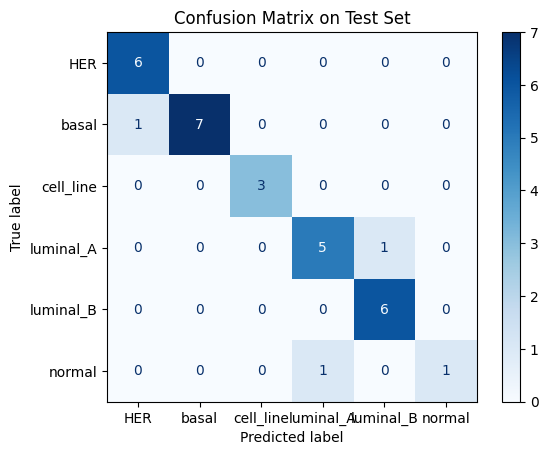

In [ ]:
# =========================
# Confusion Matrix
# =========================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

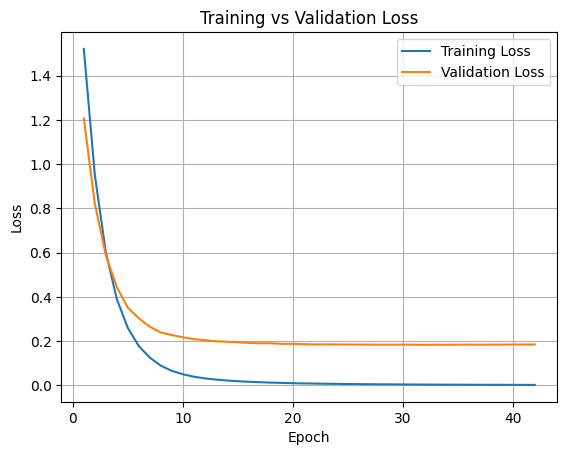

In [ ]:
# =========================
# Training vs Validation Loss Plot
# =========================

# Make sure you kept track of train_losses and val_losses during training!

epochs_range = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Top 10 genes influencing class 'HER':
Gene 121, contribution: 0.6640
Gene 199, contribution: -0.3741
Gene 196, contribution: 0.3655
Gene 154, contribution: -0.3256
Gene 58, contribution: -0.3202
Gene 104, contribution: -0.2999
Gene 245, contribution: 0.2895
Gene 106, contribution: -0.2820
Gene 223, contribution: 0.2668
Gene 190, contribution: 0.2494


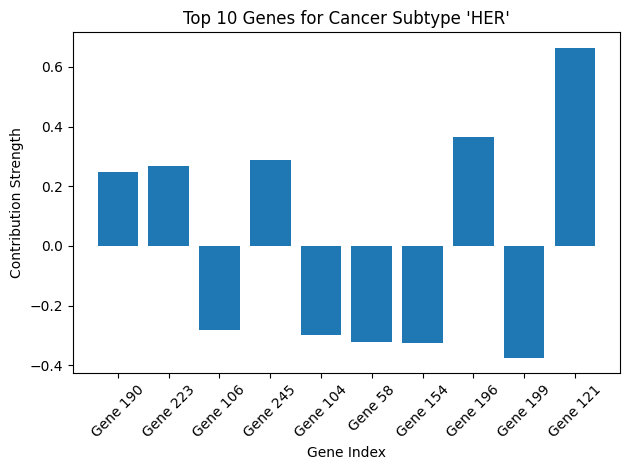


Top 10 genes influencing class 'basal':
Gene 117, contribution: 0.3307
Gene 45, contribution: 0.3235
Gene 157, contribution: -0.3057
Gene 121, contribution: -0.3040
Gene 153, contribution: -0.2966
Gene 213, contribution: 0.2846
Gene 187, contribution: 0.2781
Gene 21, contribution: -0.2781
Gene 150, contribution: 0.2676
Gene 243, contribution: -0.2650


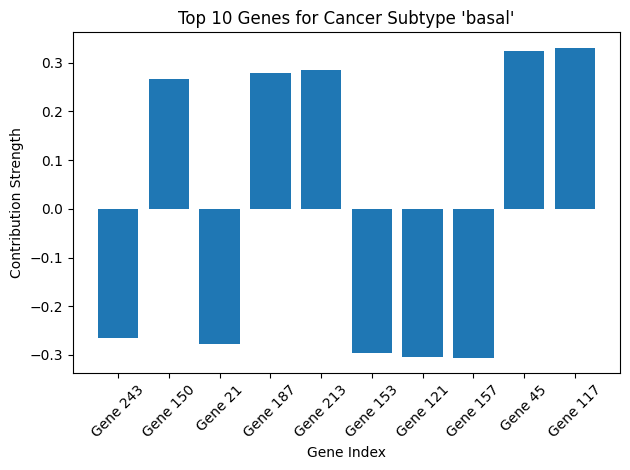


Top 10 genes influencing class 'cell_line':
Gene 198, contribution: -0.3014
Gene 210, contribution: 0.2195
Gene 239, contribution: 0.2126
Gene 19, contribution: 0.2092
Gene 241, contribution: 0.2061
Gene 5, contribution: 0.2033
Gene 167, contribution: -0.1929
Gene 41, contribution: 0.1867
Gene 136, contribution: 0.1863
Gene 207, contribution: 0.1824


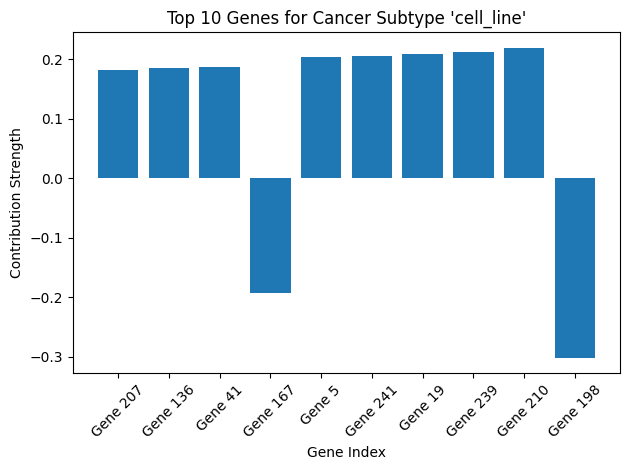


Top 10 genes influencing class 'luminal_A':
Gene 16, contribution: -0.2948
Gene 200, contribution: 0.2891
Gene 196, contribution: -0.2803
Gene 121, contribution: -0.2531
Gene 33, contribution: -0.2509
Gene 125, contribution: 0.2449
Gene 221, contribution: 0.2437
Gene 57, contribution: -0.2413
Gene 194, contribution: 0.2371
Gene 182, contribution: 0.2352


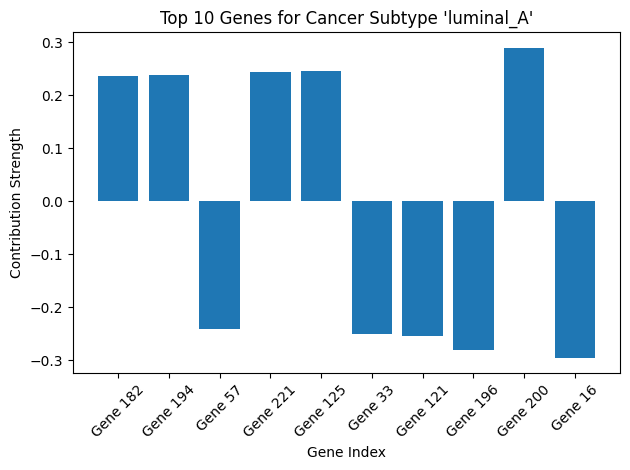


Top 10 genes influencing class 'luminal_B':
Gene 150, contribution: -0.3860
Gene 64, contribution: -0.3059
Gene 154, contribution: 0.3017
Gene 121, contribution: 0.2805
Gene 76, contribution: -0.2766
Gene 21, contribution: 0.2756
Gene 99, contribution: -0.2738
Gene 233, contribution: -0.2567
Gene 100, contribution: 0.2538
Gene 102, contribution: -0.2501


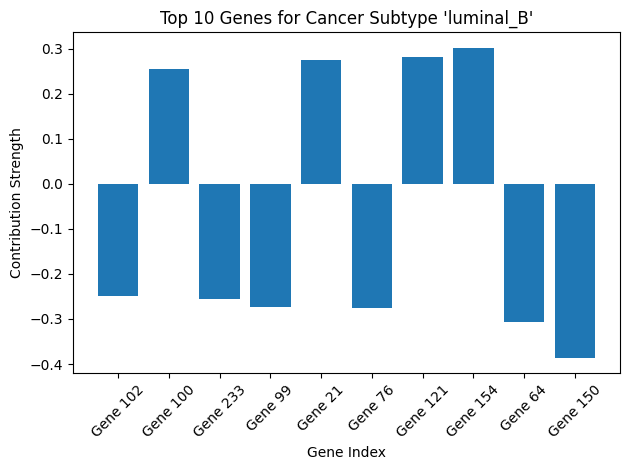


Top 10 genes influencing class 'normal':
Gene 210, contribution: 0.2955
Gene 33, contribution: -0.2054
Gene 124, contribution: 0.2051
Gene 121, contribution: -0.2024
Gene 41, contribution: 0.1846
Gene 64, contribution: 0.1777
Gene 166, contribution: 0.1693
Gene 100, contribution: -0.1676
Gene 187, contribution: 0.1667
Gene 131, contribution: -0.1659


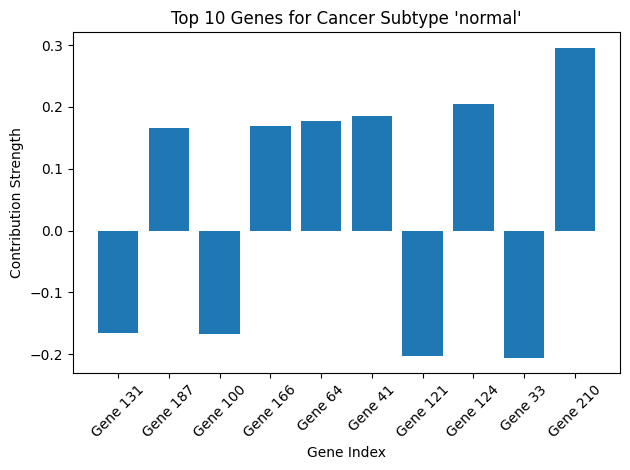

In [ ]:
# ================================
# Gene Importance Analysis Section
# ================================

# 1. Get Weights
first_layer_weights = model.fc1.weight.detach().cpu().numpy()  # (64, 250)
final_layer_weights = model.fc2.weight.detach().cpu().numpy()  # (6, 64)

# 2. For each cancer subtype (each class output)
for class_idx, class_name in enumerate(le.classes_):
    class_weights = final_layer_weights[class_idx]  # (64,)

    # 3. Trace back to input genes (through hidden layer)
    gene_contributions = np.dot(class_weights, first_layer_weights)  # (250,)

    # 4. Get top 10 most influential genes
    top_n = 10
    top_gene_indices = np.argsort(np.abs(gene_contributions))[-top_n:]

    # 5. Print top genes
    print(f"\nTop {top_n} genes influencing class '{class_name}':")
    for idx in reversed(top_gene_indices):
        print(f"Gene {idx}, contribution: {gene_contributions[idx]:.4f}")

    # 6. Plot for each class
    import matplotlib.pyplot as plt

    plt.figure()
    plt.bar(range(top_n), gene_contributions[top_gene_indices])
    plt.xticks(range(top_n), [f'Gene {i}' for i in top_gene_indices], rotation=45)
    plt.title(f"Top {top_n} Genes for Cancer Subtype '{class_name}'")
    plt.ylabel('Contribution Strength')
    plt.xlabel('Gene Index')
    plt.tight_layout()
    plt.show()